# Mask-RCNN with F-Noise

This is a notebook to show how effective is F-noise for improving mask-rcnn accuracy. Basically, F-noise behaves like augmentation method but inside the network. It changes the latent space (the features right after the backbone model) with a small range to make both augmentation and model robustness.
As a fist step I used [detectron2](https://github.com/facebookresearch/detectron2) as SOTA implementation of mask-rcnn to investigate the F-noise idea.

In [1]:
#First make sure you have the correct version of library
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")

1.9.0+cu111 True


In [2]:
#import essential libraries
import os, json, cv2, random, glob
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.logger import setup_logger

# import the utils functions from the utils dir
from utils.utils import cv2_imshow, inference_config_loder, train_config_loader, check_inf_quality

# import the new model
import models.maskrcnn


setup_logger()

<Logger detectron2 (DEBUG)>

## Adding F-noise
To impose the noise function to the model, we first took a predefined model from detectron2 library and make the change. I named this model "GeneralizedRCNN_Fnoise". I took the features from the backbone network (FPN architecture). The features are 3D matrices. For each channel, I compute the average of each channel and multiply it to a white noise and a multiplier which maintain the value of the noise in a strict bound.

In [7]:
from detectron2.modeling import META_ARCH_REGISTRY, Backbone, build_backbone, build_proposal_generator, build_roi_heads, detector_postprocess
from torch import nn
from detectron2.config import configurable
from typing import Dict, List, Optional, Tuple
from detectron2.structures import ImageList, Instances
import torch, cv2
from detectron2.utils.events import get_event_storage
from detectron2.data.detection_utils import convert_image_to_rgb
import numpy as np

@META_ARCH_REGISTRY.register()
class GeneralizedRCNN_Fnoise(nn.Module):
    """
    Generalized R-CNN. Any models that contains the following three components:
    1. Per-image feature extraction (aka backbone)
    2. Region proposal generation
    3. Per-region feature extraction and prediction
    """

    @configurable
    def __init__(
        self,
        *,
        backbone: Backbone,
        proposal_generator: nn.Module,
        roi_heads: nn.Module,
        pixel_mean: Tuple[float],
        pixel_std: Tuple[float],
        input_format: Optional[str] = None,
        vis_period: int = 0,
    ):
        """
        Args:
            backbone: a backbone module, must follow detectron2's backbone interface
            proposal_generator: a module that generates proposals using backbone features
            roi_heads: a ROI head that performs per-region computation
            pixel_mean, pixel_std: list or tuple with #channels element, representing
                the per-channel mean and std to be used to normalize the input image
            input_format: describe the meaning of channels of input. Needed by visualization
            vis_period: the period to run visualization. Set to 0 to disable.
        """
        super().__init__()
        self.backbone = backbone
        self.proposal_generator = proposal_generator
        self.roi_heads = roi_heads

        self.input_format = input_format
        self.vis_period = vis_period
        if vis_period > 0:
            assert input_format is not None, "input_format is required for visualization!"

        self.register_buffer("pixel_mean", torch.tensor(pixel_mean).view(-1, 1, 1), False)
        self.register_buffer("pixel_std", torch.tensor(pixel_std).view(-1, 1, 1), False)
        assert (
            self.pixel_mean.shape == self.pixel_std.shape
        ), f"{self.pixel_mean} and {self.pixel_std} have different shapes!"

    @classmethod
    def from_config(cls, cfg):
        backbone = build_backbone(cfg)
        return {
            "backbone": backbone,
            "proposal_generator": build_proposal_generator(cfg, backbone.output_shape()),
            "roi_heads": build_roi_heads(cfg, backbone.output_shape()),
            "input_format": cfg.INPUT.FORMAT,
            "vis_period": cfg.VIS_PERIOD,
            "pixel_mean": cfg.MODEL.PIXEL_MEAN,
            "pixel_std": cfg.MODEL.PIXEL_STD,
        }

    @property
    def device(self):
        return self.pixel_mean.device

    def visualize_training(self, batched_inputs, proposals):
        """
        A function used to visualize images and proposals. It shows ground truth
        bounding boxes on the original image and up to 20 top-scoring predicted
        object proposals on the original image. Users can implement different
        visualization functions for different models.

        Args:
            batched_inputs (list): a list that contains input to the model.
            proposals (list): a list that contains predicted proposals. Both
                batched_inputs and proposals should have the same length.
        """
        from detectron2.utils.visualizer import Visualizer

        storage = get_event_storage()
        max_vis_prop = 20

        for input, prop in zip(batched_inputs, proposals):
            img = input["image"]
            img = convert_image_to_rgb(img.permute(1, 2, 0), self.input_format)
            v_gt = Visualizer(img, None)
            v_gt = v_gt.overlay_instances(boxes=input["instances"].gt_boxes)
            anno_img = v_gt.get_image()
            box_size = min(len(prop.proposal_boxes), max_vis_prop)
            v_pred = Visualizer(img, None)
            v_pred = v_pred.overlay_instances(
                boxes=prop.proposal_boxes[0:box_size].tensor.cpu().numpy()
            )
            prop_img = v_pred.get_image()
            vis_img = np.concatenate((anno_img, prop_img), axis=1)
            vis_img = vis_img.transpose(2, 0, 1)
            vis_name = "Left: GT bounding boxes;  Right: Predicted proposals"
            storage.put_image(vis_name, vis_img)
            break  # only visualize one image in a batch

    def forward(self, batched_inputs: List[Dict[str, torch.Tensor]]):
        """
        Args:
            batched_inputs: a list, batched outputs of :class:`DatasetMapper` .
                Each item in the list contains the inputs for one image.
                For now, each item in the list is a dict that contains:

                * image: Tensor, image in (C, H, W) format.
                * instances (optional): groundtruth :class:`Instances`
                * proposals (optional): :class:`Instances`, precomputed proposals.

                Other information that's included in the original dicts, such as:

                * "height", "width" (int): the output resolution of the model, used in inference.
                  See :meth:`postprocess` for details.

        Returns:
            list[dict]:
                Each dict is the output for one input image.
                The dict contains one key "instances" whose value is a :class:`Instances`.
                The :class:`Instances` object has the following keys:
                "pred_boxes", "pred_classes", "scores", "pred_masks", "pred_keypoints"
        """
        if not self.training:
            return self.inference(batched_inputs)

        images = self.preprocess_image(batched_inputs)
        if "instances" in batched_inputs[0]:
            gt_instances = [x["instances"].to(self.device) for x in batched_inputs]
        else:
            gt_instances = None

        features = self.backbone(images.tensor)
        for key, feat in features.items():
            features[key] = features[key] + 1e-3 * torch.randn_like(feat).cuda() * torch.norm(feat, p=2, dim=(2, 3),
                                                                                     keepdim=True)
                                                                            keepdim=True)

        if self.proposal_generator is not None:
            proposals, proposal_losses = self.proposal_generator(images, features, gt_instances)
        else:
            assert "proposals" in batched_inputs[0]
            proposals = [x["proposals"].to(self.device) for x in batched_inputs]
            proposal_losses = {}

        _, detector_losses = self.roi_heads(images, features, proposals, gt_instances)
        if self.vis_period > 0:
            storage = get_event_storage()
            if storage.iter % self.vis_period == 0:
                self.visualize_training(batched_inputs, proposals)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)
        return losses

    def inference(
        self,
        batched_inputs: List[Dict[str, torch.Tensor]],
        detected_instances: Optional[List[Instances]] = None,
        do_postprocess: bool = True,
    ):
        """
        Run inference on the given inputs.

        Args:
            batched_inputs (list[dict]): same as in :meth:`forward`
            detected_instances (None or list[Instances]): if not None, it
                contains an `Instances` object per image. The `Instances`
                object contains "pred_boxes" and "pred_classes" which are
                known boxes in the image.
                The inference will then skip the detection of bounding boxes,
                and only predict other per-ROI outputs.
            do_postprocess (bool): whether to apply post-processing on the outputs.

        Returns:
            When do_postprocess=True, same as in :meth:`forward`.
            Otherwise, a list[Instances] containing raw network outputs.
        """
        assert not self.training

        images = self.preprocess_image(batched_inputs)
        features = self.backbone(images.tensor)

        if detected_instances is None:
            if self.proposal_generator is not None:
                proposals, _ = self.proposal_generator(images, features, None)
            else:
                assert "proposals" in batched_inputs[0]
                proposals = [x["proposals"].to(self.device) for x in batched_inputs]

            results, _ = self.roi_heads(images, features, proposals, None)
        else:
            detected_instances = [x.to(self.device) for x in detected_instances]
            results = self.roi_heads.forward_with_given_boxes(features, detected_instances)

        if do_postprocess:
            assert not torch.jit.is_scripting(), "Scripting is not supported for postprocess."
            return GeneralizedRCNN_Fnoise._postprocess(results, batched_inputs, images.image_sizes)
        else:
            return results

    def preprocess_image(self, batched_inputs: List[Dict[str, torch.Tensor]]):
        """
        Normalize, pad and batch the input images.
        """
        images = [x["image"].to(self.device) for x in batched_inputs]
        images = [(x - self.pixel_mean) / self.pixel_std for x in images]
        images = ImageList.from_tensors(images, self.backbone.size_divisibility)
        return images

    @staticmethod
    def _postprocess(instances, batched_inputs: List[Dict[str, torch.Tensor]], image_sizes):
        """
        Rescale the output instances to the target size.
        """
        # note: private function; subject to changes
        processed_results = []
        for results_per_image, input_per_image, image_size in zip(
            instances, batched_inputs, image_sizes
        ):
            height = input_per_image.get("height", image_size[0])
            width = input_per_image.get("width", image_size[1])
            r = detector_postprocess(results_per_image, height, width)
            processed_results.append({"instances": r})
        return processed_results

In [9]:
# take the net and train hyperparams
cfg = get_cfg()
cfg = train_config_loader(cfg, pretrain=False)
cfg.OUTPUT_DIR = 'test'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300
cfg.VIS_PERIOD = 20
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/24 11:45:56 d2.engine.defaults]: Model:
GeneralizedRCNN_Fnoise(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
   

[10/24 11:45:56 d2.data.datasets.coco]: Loaded 5000 images in COCO format from datasets/coco/annotations/instances_val2017.json
[10/24 11:45:56 d2.data.build]: Removed 48 images with no usable annotations. 4952 images left.
[10/24 11:45:56 d2.data.build]: Distribution of instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 10777        |   bicycle    | 314          |      car      | 1918         |
|  motorcycle   | 367          |   airplane   | 143          |      bus      | 283          |
|     train     | 190          |    truck     | 414          |     boat      | 424          |
| traffic light | 634          | fire hydrant | 101          |   stop sign   | 75           |
| parking meter | 60           |    bench     | 411          |     bird      | 427          |
|      cat      | 202          |   

/home/amir_shirian/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/amir_shirian/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation

[10/24 11:46:11 d2.utils.events]:  eta: 0:03:09  iter: 19  total_loss: 93.18  loss_cls: 74.79  loss_box_reg: 2.702  loss_mask: 1.552  loss_rpn_cls: 4.193  loss_rpn_loc: 7.762  time: 0.6794  data_time: 0.0508  lr: 1.6068e-05  max_mem: 6642M
[10/24 11:46:24 d2.utils.events]:  eta: 0:02:51  iter: 39  total_loss: 6.934  loss_cls: 3.651  loss_box_reg: 0.589  loss_mask: 0.7749  loss_rpn_cls: 0.6137  loss_rpn_loc: 0.9943  time: 0.6743  data_time: 0.0491  lr: 3.2718e-05  max_mem: 6642M
[10/24 11:46:37 d2.utils.events]:  eta: 0:02:36  iter: 59  total_loss: 4.113  loss_cls: 1.733  loss_box_reg: 0.4564  loss_mask: 0.7093  loss_rpn_cls: 0.4891  loss_rpn_loc: 0.4759  time: 0.6614  data_time: 0.0455  lr: 4.9367e-05  max_mem: 6642M
[10/24 11:46:52 d2.utils.events]:  eta: 0:02:24  iter: 79  total_loss: 3.324  loss_cls: 1.279  loss_box_reg: 0.4486  loss_mask: 0.6769  loss_rpn_cls: 0.4686  loss_rpn_loc: 0.4143  time: 0.6696  data_time: 0.0511  lr: 6.6017e-05  max_mem: 6642M
[10/24 11:47:06 d2.utils.even

The model is clearly works and the losses become smaller as the training step increases.

## Evaluation

In [ ]:
# load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

The results will store in output folder with tensorboard support. I put some of the figures from tensorboard below.

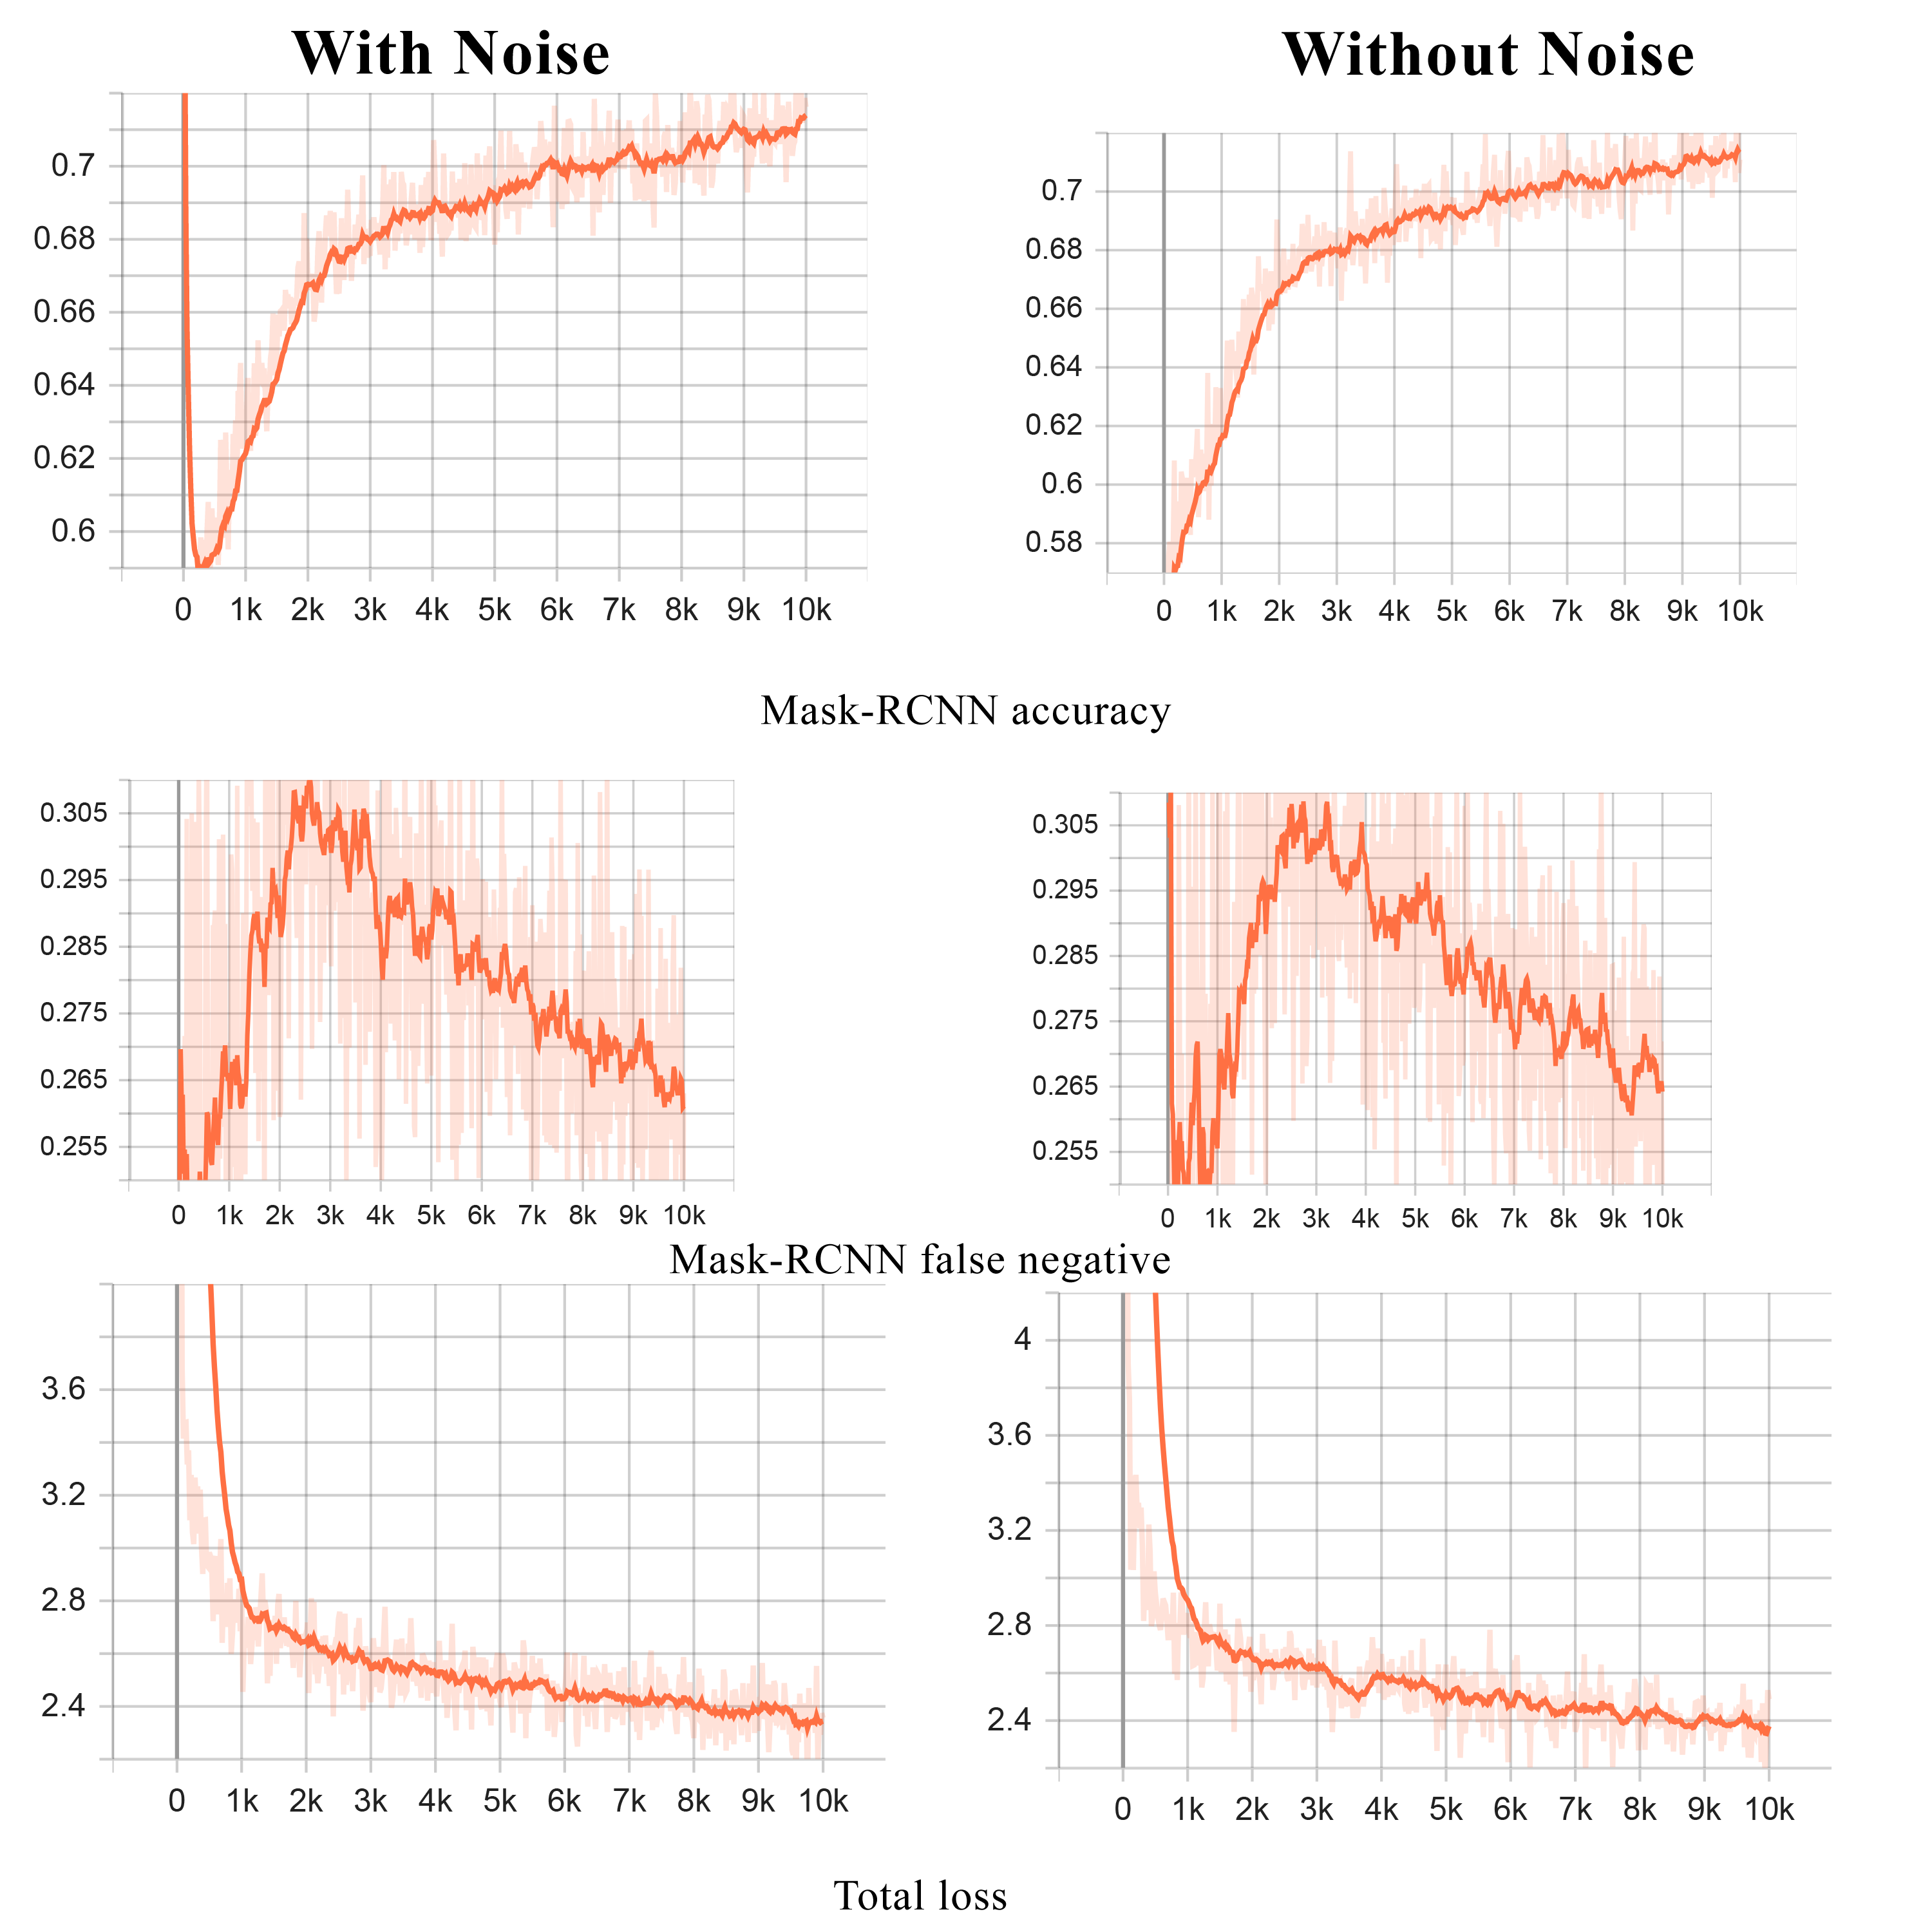

In [2]:
from IPython.core.display import Image, display, SVG
display(Image(filename='result_figures/mask_rcnn_accuracy.png' , width=700, unconfined=True))

| Metric | With F-noise | without noise |
|-------|-------------|----------|
| Mask-rcnn accuracy | 0.71 | 0.73 |
| Mask-rcnn FN | 0.23 | 0.24 |
| Mask-rcnn total loss | 2.0 | 2.3 |

I process one image from outside of the data training with both networks. You can see the results in the below. The top image is from the network trained with F-noise. Both networks have poor results because the network itself is a huge network and needs a lot of training data but you can see that the network with F-noise performs relatively better. Note that the data we used for training has a big portion of person labels. Thus the networks predictions are more into finding humans.


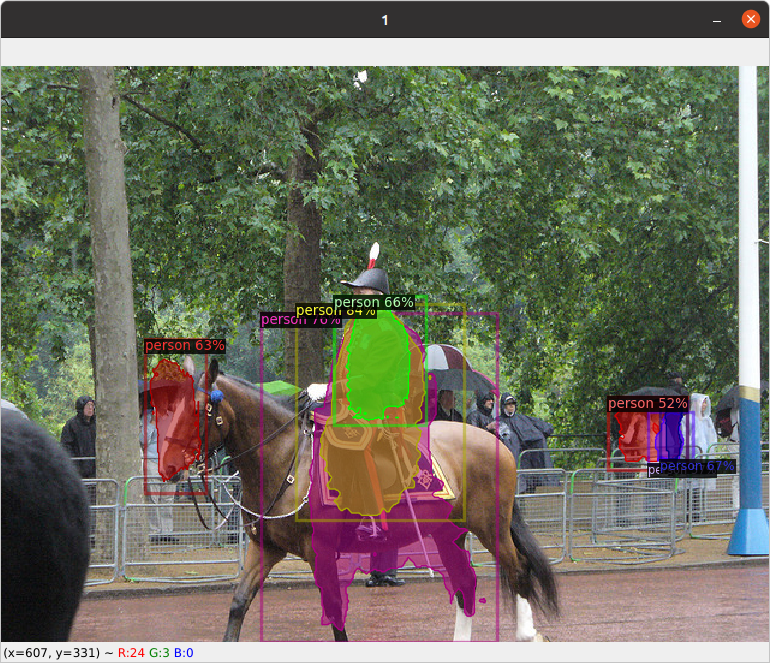

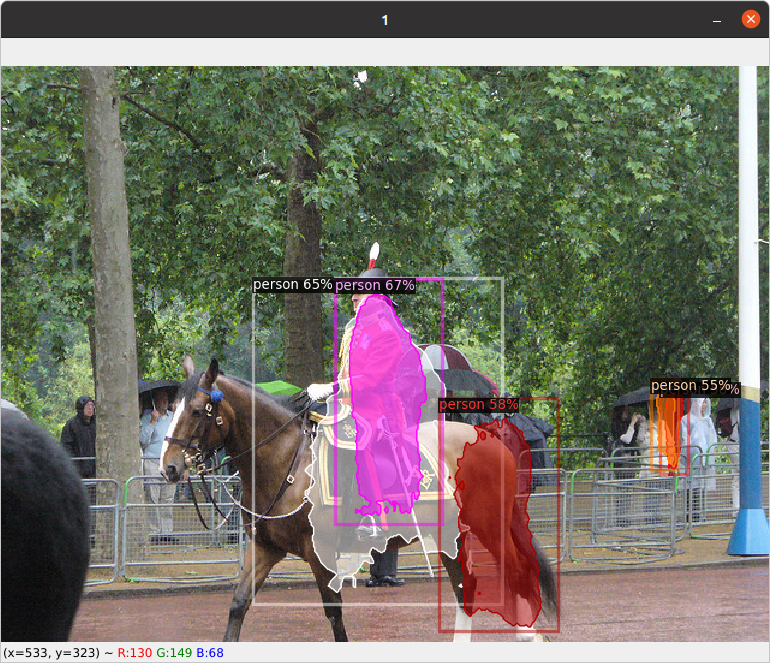

In [4]:
display(Image(filename='result_figures/with.png' , width=300, unconfined=True))
display(Image(filename='result_figures/without.png' , width=300, unconfined=True))

I also provide the mask detection output during training for both networks. Each image have two section. The left part is the predicted mask with the corresponding network and the right part is ground truth. The top row is related to the network with F-noise and the bottom one is for the network without F-noise. As you can see, as the training steps increases, the quality of mask is getting better for both network but the network with F-noise is much better. Especially the 3rd column, the both masks represent a giraff but the top row mask has much better prediction result.

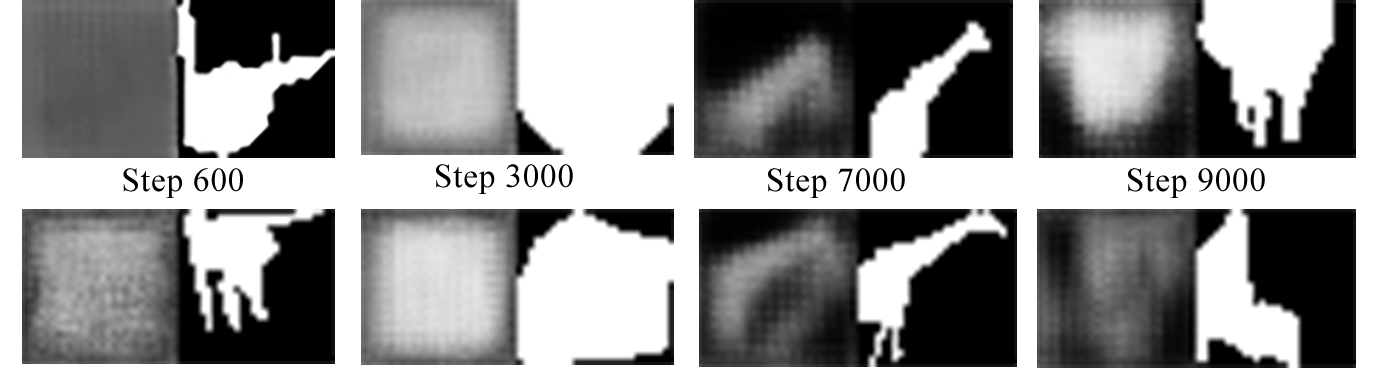

In [6]:
display(Image(filename='result_figures/mask.png' , width=700, unconfined=True))